https://mybinder.org/v2/gh/ZHAW-dm4bem-2023/reproducible-report-gianluca/HEAD


Maximum time step: 5599.12 s = 93.32 min
dt = 3600 s = 60.0 min
duration = 5004000 s = 1390.0 h


<Axes: xlabel='Index'>

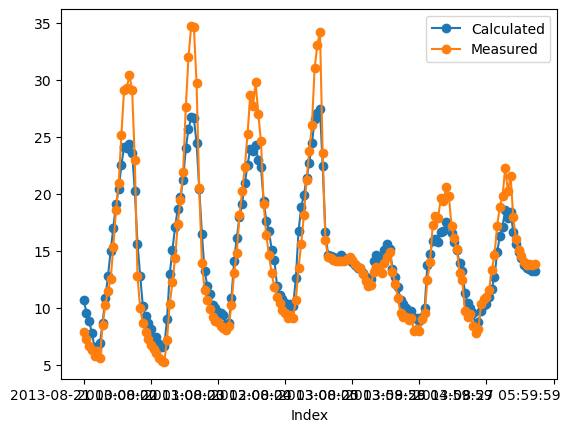

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 26 14:53:09 2023

@author: gianl
"""

import pandas as pd
import dm4bem
import numpy as np
import matplotlib.pyplot as plt

wall_types = pd.read_csv('C:/Users/gianl/OneDrive/Desktop/EVA Project/wall_types.csv')

walls = pd.read_csv('C:/Users/gianl/OneDrive/Desktop/EVA Project/walls_out.csv')

TCd = dm4bem.bldg2TCd('C:/Users/gianl/OneDrive/Desktop/EVA Project',
                      TC_auto_number=True)

ass_lists = pd.read_csv('C:/Users/gianl/OneDrive/Desktop/EVA Project/assembly_lists.csv',sep=';')
ass_mat = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_mat)

# State-space from TC
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

dtmax = 2 * min(-1. / λ) # max time step for Euler explicit stability
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

t_settle = 4 * max(-1. / λ)
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

'-------------------------------------------------------------------------------------------------------'
'''
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                     periods=n, freq=f"{int(dt)}S")

To = 10 * np.ones(n)
Ti = 25 * np.ones(n)
Qo = 0 * np.ones(n)
Qi = Qo 

data = {'To': To, 'Ti': Ti, 'Qo': Qo, 'Qi': Qi}
input_data_set = pd.DataFrame(data, index=time)

# Get input u from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0
θ_imp = θ_exp

I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])
        
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)
y.plot();

'''
#Simulation with weather data 

Input_data = pd.read_csv('C:/Users/gianl/OneDrive/Desktop/EVA Project/Input_Data.csv', index_col=0, usecols=['Index','To','Qo','Qi','Ti'], sep=';')
Validation_data = pd.read_csv('C:/Users/gianl/OneDrive/Desktop/EVA Project/Validation_Data.csv', index_col=0, usecols=['Index','T0_sur'], sep=';')

#Input
To = Input_data['To']
Ti = Input_data['Ti']

Etot = Input_data['Qo']
Qo = walls['α1'].values[0]*walls['Area'].values[0]*Etot
Qi = Input_data['Qi']


# Input data set
input_data_set = pd.DataFrame({'To': To, 'Ti': Ti, 'Qo': Qo, 'Qi': Qi})


# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# initial conditions
θ0 = 20                      # initial temperatures
θ_exp = pd.DataFrame(index=u.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0

# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]


y = (Cs @ θ_exp.T + Ds @  u.T).T


data = pd.DataFrame({'T_sur_calculated': y['ow0_θ0'],
                     'T_sur_measured': Validation_data['T0_sur']})


data.plot(y=['T_sur_calculated', 'T_sur_measured'], kind='line', marker='o', linestyle='-', label=['Calculated', 'Measured'])